### 1 Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string
import warnings

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from wordcloud import WordCloud, ImageColorGenerator

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from googletrans import Translator, constants
import emoji

# To mock web-browser and scrap tweets
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

# To consume Twitter's API
import tweepy
from tweepy import OAuthHandler 

# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

# for showing all the plots inline
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sowmiya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sowmiya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sowmiya/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sowmiya/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/sowmiya/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sowmiya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/sowmiya/nltk_data...
[nltk_data]   Package 

### 2 Fetch tweets 

#### 2.1 Fetch tweets using tweepy

In [2]:
consumer_key = 'Sec3MvclRIx2RVlgu9l0SJX6D'
consumer_secret = 'ayoPNWtBm7fWpMBoK6EwRmegu3SW8Rw9mzJkottkv97quPe941'
access_token = '736550752760406018-so5CPJrEbJKb3c3Pq8va3VFr0yk4S0E'
access_token_secret = 'Cgr8tz0h6FTU7kxAjDzpHnjffNTHxWsBytXnu4Ihd1TFb'

In [3]:
class TwitterClient(object): 
    def __init__(self): 
        #Initialization method. 
        try: 
            # create OAuthHandler object 
            auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            # add hyper parameter 'proxy' if executing from behind proxy "proxy='http://172.22.218.218:8085'"
            self.api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
            
        except tweepy.TweepError as e:
            print(f"Error: Tweeter Authentication Failed - \n{str(e)}")

    def get_tweets(self, query, maxTweets = 1000):
        #Function to fetch tweets. 
        # empty list to store parsed tweets 
        tweets = [] 
        sinceId = None
        max_id = -1
        tweetCount = 0
        tweetsPerQry = 100

        while tweetCount < maxTweets:
            try:
                if (max_id <= 0):
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry)
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                since_id=sinceId)
                else:
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,max_id=str(max_id - 1))
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1),
                                                since_id=sinceId)
                if not new_tweets:
                    print("No more tweets found")
                    break

                for tweet in new_tweets:
                    parsed_tweet = {} 
                    parsed_tweet['tweets'] = tweet.text 

                    # appending parsed tweet to tweets list 
                    if tweet.retweet_count > 0: 
                        # if tweet has retweets, ensure that it is appended only once 
                        if parsed_tweet not in tweets: 
                            tweets.append(parsed_tweet) 
                    else: 
                        tweets.append(parsed_tweet) 
                        
                tweetCount += len(new_tweets)
                print("Downloaded {0} tweets".format(tweetCount))
                max_id = new_tweets[-1].id
            except tweepy.TweepError as e:
                # Just exit if any error
                print("Tweepy error : " + str(e))
                break
        
        return pd.DataFrame(tweets)

In [4]:
twitter_client = TwitterClient()

# calling function to get tweets
tweets_df = twitter_client.get_tweets('iOS 14', maxTweets=20000)

Downloaded 100 tweets
Downloaded 200 tweets
Downloaded 300 tweets
Downloaded 400 tweets
Downloaded 500 tweets
Downloaded 600 tweets
Downloaded 700 tweets
Downloaded 800 tweets
Downloaded 900 tweets
Downloaded 1000 tweets
Downloaded 1100 tweets
Downloaded 1200 tweets
Downloaded 1300 tweets
Downloaded 1400 tweets
Downloaded 1500 tweets
Downloaded 1600 tweets
Downloaded 1700 tweets
Downloaded 1800 tweets
Downloaded 1900 tweets
Downloaded 2000 tweets
Downloaded 2100 tweets
Downloaded 2200 tweets
Downloaded 2300 tweets
Downloaded 2400 tweets
Downloaded 2500 tweets
Downloaded 2600 tweets
Downloaded 2700 tweets
Downloaded 2800 tweets
Downloaded 2900 tweets
Downloaded 3000 tweets
Downloaded 3100 tweets
Downloaded 3200 tweets
Downloaded 3300 tweets
Downloaded 3400 tweets
Downloaded 3499 tweets
Downloaded 3599 tweets
Downloaded 3699 tweets
Downloaded 3799 tweets
Downloaded 3899 tweets
Downloaded 3999 tweets
Downloaded 4099 tweets
Downloaded 4199 tweets
Downloaded 4299 tweets
Downloaded 4399 twee

Rate limit reached. Sleeping for: 736


Downloaded 18080 tweets
Downloaded 18180 tweets
Downloaded 18280 tweets
Downloaded 18380 tweets
Downloaded 18480 tweets
Downloaded 18580 tweets
Downloaded 18680 tweets
Downloaded 18780 tweets
Downloaded 18880 tweets
Downloaded 18980 tweets
Downloaded 19080 tweets
Downloaded 19180 tweets
Downloaded 19280 tweets
Downloaded 19380 tweets
Downloaded 19480 tweets
Downloaded 19580 tweets
Downloaded 19680 tweets
Downloaded 19780 tweets
Downloaded 19880 tweets
Downloaded 19980 tweets
Downloaded 20080 tweets


In [5]:
print(f'tweets_df Shape - {tweets_df.shape}')
tweets_df

tweets_df Shape - (15589, 1)


,tweets
0,iOS 14めちゃ電池消耗が激しい気がする。
1,RT @BrightMinho: iPad มันควรดู 4K ใน YouTube ไ...
2,ios 14로 업뎃 됐는 데...못 꾸미겠네요 허허 내가 똥손이었음을 다시 한번 느끼네요
3,kok bisa ya orang-orang tampilan menu di ios 1...
4,@aaplpro Интересно iOS 14.2 выйдет ли 10 или р...
...,...
15584,fuck beta iOS 14 like why has it taken the ent...
15585,Woke up to iOS 14 update. This is mad cool. ❄️...
15586,@SteveMoser I actually got this message long t...
15587,Imma get the ios 14 later- \nMe still scared ;...


### 2 Tweets cleaning

##### 2.1.1 Removing '@names'

In [6]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    return text

tweets_df['tidy_tweets'] = np.vectorize(remove_pattern)(tweets_df['tweets'], "@[\w]*: | *RT*")
tweets_df['tidy_tweets'] = np.vectorize(remove_pattern)(tweets_df['tidy_tweets'], "@[\w]* | *RT*")

tweets_df.head(10)

,tweets,tidy_tweets
0,iOS 14めちゃ電池消耗が激しい気がする。,iOS 14めちゃ電池消耗が激しい気がする。
1,RT @BrightMinho: iPad มันควรดู 4K ใน YouTube ไ...,iPad มันควรดู 4K ใน YouTube ได้นานแล้ว เพราะม...
2,ios 14로 업뎃 됐는 데...못 꾸미겠네요 허허 내가 똥손이었음을 다시 한번 느끼네요,ios 14로 업뎃 됐는 데...못 꾸미겠네요 허허 내가 똥손이었음을 다시 한번 느끼네요
3,kok bisa ya orang-orang tampilan menu di ios 1...,kok bisa ya orang-orang tampilan menu di ios 1...
4,@aaplpro Интересно iOS 14.2 выйдет ли 10 или р...,Интересно iOS 14.2 выйдет ли 10 или раньше 🤔
5,@nico_roshi 分かる…ワイも最近、iOS 14にアップグレードしたら、追加された機...,分かる…ワイも最近、iOS 14にアップグレードしたら、追加された機能でキレそうになった…マ...
6,RT @John97867: #Flossy @SteveMeyer420 😍🤟🏼\n G...,#Flossy 😍🤟🏼\n Great theme for iOS 14\n#Widge...
7,APPLE MUSIC 🔥\n(support ios 14)\n\n3 bulan : 2...,APPLE MUSIC 🔥\n(support ios 14)\n\n3 bulan : 2...
8,RT @CaschysBlog: Safari unter iOS 14: So übers...,Safari unter iOS 14: So übersetzt man Webseit...
9,RT @applenws: How to Fix iOS 14 &amp; iPadOS 1...,How to Fix iOS 14 &amp; iPadOS 14 Wi-Fi Probl...


##### 2.1.2 Removing links (http| https)

In [7]:
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tidy_tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets_df['tidy_tweets'] = cleaned_tweets
tweets_df.head(10)

,tweets,tidy_tweets
0,iOS 14めちゃ電池消耗が激しい気がする。,iOS 14めちゃ電池消耗が激しい気がする。
1,RT @BrightMinho: iPad มันควรดู 4K ใน YouTube ไ...,iPad มันควรดู 4K ใน YouTube ได้นานแล้ว เพราะมั...
2,ios 14로 업뎃 됐는 데...못 꾸미겠네요 허허 내가 똥손이었음을 다시 한번 느끼네요,ios 14로 업뎃 됐는 데...못 꾸미겠네요 허허 내가 똥손이었음을 다시 한번 느끼네요
3,kok bisa ya orang-orang tampilan menu di ios 1...,kok bisa ya orang-orang tampilan menu di ios 1...
4,@aaplpro Интересно iOS 14.2 выйдет ли 10 или р...,Интересно iOS 14.2 выйдет ли 10 или раньше 🤔
5,@nico_roshi 分かる…ワイも最近、iOS 14にアップグレードしたら、追加された機...,分かる…ワイも最近、iOS 14にアップグレードしたら、追加された機能でキレそうになった…マ...
6,RT @John97867: #Flossy @SteveMeyer420 😍🤟🏼\n G...,#Flossy 😍🤟🏼 Great theme for iOS 14 #WidgetTool...
7,APPLE MUSIC 🔥\n(support ios 14)\n\n3 bulan : 2...,APPLE MUSIC 🔥 (support ios 14) 3 bulan : 25.00...
8,RT @CaschysBlog: Safari unter iOS 14: So übers...,Safari unter iOS 14: So übersetzt man Webseite...
9,RT @applenws: How to Fix iOS 14 &amp; iPadOS 1...,How to Fix iOS 14 &amp; iPadOS 14 Wi-Fi Problems


##### 2.1.3 Removing tweets with empty text

In [8]:
tweets_df = tweets_df[tweets_df['tidy_tweets']!='']
tweets_df.head(10)

,tweets,tidy_tweets
0,iOS 14めちゃ電池消耗が激しい気がする。,iOS 14めちゃ電池消耗が激しい気がする。
1,RT @BrightMinho: iPad มันควรดู 4K ใน YouTube ไ...,iPad มันควรดู 4K ใน YouTube ได้นานแล้ว เพราะมั...
2,ios 14로 업뎃 됐는 데...못 꾸미겠네요 허허 내가 똥손이었음을 다시 한번 느끼네요,ios 14로 업뎃 됐는 데...못 꾸미겠네요 허허 내가 똥손이었음을 다시 한번 느끼네요
3,kok bisa ya orang-orang tampilan menu di ios 1...,kok bisa ya orang-orang tampilan menu di ios 1...
4,@aaplpro Интересно iOS 14.2 выйдет ли 10 или р...,Интересно iOS 14.2 выйдет ли 10 или раньше 🤔
5,@nico_roshi 分かる…ワイも最近、iOS 14にアップグレードしたら、追加された機...,分かる…ワイも最近、iOS 14にアップグレードしたら、追加された機能でキレそうになった…マ...
6,RT @John97867: #Flossy @SteveMeyer420 😍🤟🏼\n G...,#Flossy 😍🤟🏼 Great theme for iOS 14 #WidgetTool...
7,APPLE MUSIC 🔥\n(support ios 14)\n\n3 bulan : 2...,APPLE MUSIC 🔥 (support ios 14) 3 bulan : 25.00...
8,RT @CaschysBlog: Safari unter iOS 14: So übers...,Safari unter iOS 14: So übersetzt man Webseite...
9,RT @applenws: How to Fix iOS 14 &amp; iPadOS 1...,How to Fix iOS 14 &amp; iPadOS 14 Wi-Fi Problems


##### 2.1.4 Dropping duplicate rows

In [9]:
tweets_df.drop_duplicates(subset=['tidy_tweets'], keep=False)
tweets_df.head(10)

,tweets,tidy_tweets
0,iOS 14めちゃ電池消耗が激しい気がする。,iOS 14めちゃ電池消耗が激しい気がする。
1,RT @BrightMinho: iPad มันควรดู 4K ใน YouTube ไ...,iPad มันควรดู 4K ใน YouTube ได้นานแล้ว เพราะมั...
2,ios 14로 업뎃 됐는 데...못 꾸미겠네요 허허 내가 똥손이었음을 다시 한번 느끼네요,ios 14로 업뎃 됐는 데...못 꾸미겠네요 허허 내가 똥손이었음을 다시 한번 느끼네요
3,kok bisa ya orang-orang tampilan menu di ios 1...,kok bisa ya orang-orang tampilan menu di ios 1...
4,@aaplpro Интересно iOS 14.2 выйдет ли 10 или р...,Интересно iOS 14.2 выйдет ли 10 или раньше 🤔
5,@nico_roshi 分かる…ワイも最近、iOS 14にアップグレードしたら、追加された機...,分かる…ワイも最近、iOS 14にアップグレードしたら、追加された機能でキレそうになった…マ...
6,RT @John97867: #Flossy @SteveMeyer420 😍🤟🏼\n G...,#Flossy 😍🤟🏼 Great theme for iOS 14 #WidgetTool...
7,APPLE MUSIC 🔥\n(support ios 14)\n\n3 bulan : 2...,APPLE MUSIC 🔥 (support ios 14) 3 bulan : 25.00...
8,RT @CaschysBlog: Safari unter iOS 14: So übers...,Safari unter iOS 14: So übersetzt man Webseite...
9,RT @applenws: How to Fix iOS 14 &amp; iPadOS 1...,How to Fix iOS 14 &amp; iPadOS 14 Wi-Fi Problems


##### 2.1.5 Resetting Index

In [10]:
tweets_df = tweets_df.reset_index(drop=True)
tweets_df.head(10)

,tweets,tidy_tweets
0,iOS 14めちゃ電池消耗が激しい気がする。,iOS 14めちゃ電池消耗が激しい気がする。
1,RT @BrightMinho: iPad มันควรดู 4K ใน YouTube ไ...,iPad มันควรดู 4K ใน YouTube ได้นานแล้ว เพราะมั...
2,ios 14로 업뎃 됐는 데...못 꾸미겠네요 허허 내가 똥손이었음을 다시 한번 느끼네요,ios 14로 업뎃 됐는 데...못 꾸미겠네요 허허 내가 똥손이었음을 다시 한번 느끼네요
3,kok bisa ya orang-orang tampilan menu di ios 1...,kok bisa ya orang-orang tampilan menu di ios 1...
4,@aaplpro Интересно iOS 14.2 выйдет ли 10 или р...,Интересно iOS 14.2 выйдет ли 10 или раньше 🤔
5,@nico_roshi 分かる…ワイも最近、iOS 14にアップグレードしたら、追加された機...,分かる…ワイも最近、iOS 14にアップグレードしたら、追加された機能でキレそうになった…マ...
6,RT @John97867: #Flossy @SteveMeyer420 😍🤟🏼\n G...,#Flossy 😍🤟🏼 Great theme for iOS 14 #WidgetTool...
7,APPLE MUSIC 🔥\n(support ios 14)\n\n3 bulan : 2...,APPLE MUSIC 🔥 (support ios 14) 3 bulan : 25.00...
8,RT @CaschysBlog: Safari unter iOS 14: So übers...,Safari unter iOS 14: So übersetzt man Webseite...
9,RT @applenws: How to Fix iOS 14 &amp; iPadOS 1...,How to Fix iOS 14 &amp; iPadOS 14 Wi-Fi Problems


##### 2.1.6 Translating tweets from any language to english using googletranslate API

In [11]:
tweets_df['tweets_en'] = ''
translator = Translator()
for i in range(len(tweets_df)):
    tweet = tweets_df['tidy_tweets'][i]
    translation = translator.translate(tweet)
    tweets_df['tweets_en'][i] = translation.text
tweets_df.head(10)

,tweets,tidy_tweets,tweets_en
0,iOS 14めちゃ電池消耗が激しい気がする。,iOS 14めちゃ電池消耗が激しい気がする。,iOS 14 I feel that the battery is exhausted.
1,RT @BrightMinho: iPad มันควรดู 4K ใน YouTube ไ...,iPad มันควรดู 4K ใน YouTube ได้นานแล้ว เพราะมั...,"iPad, it should be able to watch 4K on YouTube..."
2,ios 14로 업뎃 됐는 데...못 꾸미겠네요 허허 내가 똥손이었음을 다시 한번 느끼네요,ios 14로 업뎃 됐는 데...못 꾸미겠네요 허허 내가 똥손이었음을 다시 한번 느끼네요,I was updated to ios 14... but I can't decorat...
3,kok bisa ya orang-orang tampilan menu di ios 1...,kok bisa ya orang-orang tampilan menu di ios 1...,how come people display the menu on ios 14 is ...
4,@aaplpro Интересно iOS 14.2 выйдет ли 10 или р...,Интересно iOS 14.2 выйдет ли 10 или раньше 🤔,I wonder if iOS 14.2 will come out 10 or earli...
5,@nico_roshi 分かる…ワイも最近、iOS 14にアップグレードしたら、追加された機...,分かる…ワイも最近、iOS 14にアップグレードしたら、追加された機能でキレそうになった…マ...,"I see ... Wai recently upgraded to iOS 14, and..."
6,RT @John97867: #Flossy @SteveMeyer420 😍🤟🏼\n G...,#Flossy 😍🤟🏼 Great theme for iOS 14 #WidgetTool...,#Flossy 😍🤟🏼 Great theme for iOS 14 #WidgetTool...
7,APPLE MUSIC 🔥\n(support ios 14)\n\n3 bulan : 2...,APPLE MUSIC 🔥 (support ios 14) 3 bulan : 25.00...,APPLE MUSIC 🔥 (support ios 14) 3 bulan : 25.00...
8,RT @CaschysBlog: Safari unter iOS 14: So übers...,Safari unter iOS 14: So übersetzt man Webseite...,Safari on iOS 14: How to translate websites in...
9,RT @applenws: How to Fix iOS 14 &amp; iPadOS 1...,How to Fix iOS 14 &amp; iPadOS 14 Wi-Fi Problems,How to Fix iOS 14 &amp; iPadOS 14 Wi-Fi Problems


##### 2.1.7  Removing Punctuations, Numbers and Special characters

In [14]:
tweets_df['absolute_tidy_tweets'] = tweets_df['tweets_en'].str.replace("[^a-zA-Z# ]", "")
tweets_df.head(10)

,tweets,tidy_tweets,tweets_en,absolute_tidy_tweets
0,iOS 14めちゃ電池消耗が激しい気がする。,iOS 14めちゃ電池消耗が激しい気がする。,iOS 14 I feel that the battery is exhausted.,iOS I feel that the battery is exhausted
1,RT @BrightMinho: iPad มันควรดู 4K ใน YouTube ไ...,iPad มันควรดู 4K ใน YouTube ได้นานแล้ว เพราะมั...,"iPad, it should be able to watch 4K on YouTube...",iPad it should be able to watch K on YouTube f...
2,ios 14로 업뎃 됐는 데...못 꾸미겠네요 허허 내가 똥손이었음을 다시 한번 느끼네요,ios 14로 업뎃 됐는 데...못 꾸미겠네요 허허 내가 똥손이었음을 다시 한번 느끼네요,I was updated to ios 14... but I can't decorat...,I was updated to ios but I cant decorate it
3,kok bisa ya orang-orang tampilan menu di ios 1...,kok bisa ya orang-orang tampilan menu di ios 1...,how come people display the menu on ios 14 is ...,how come people display the menu on ios is good
4,@aaplpro Интересно iOS 14.2 выйдет ли 10 или р...,Интересно iOS 14.2 выйдет ли 10 или раньше 🤔,I wonder if iOS 14.2 will come out 10 or earli...,I wonder if iOS will come out or earlier
5,@nico_roshi 分かる…ワイも最近、iOS 14にアップグレードしたら、追加された機...,分かる…ワイも最近、iOS 14にアップグレードしたら、追加された機能でキレそうになった…マ...,"I see ... Wai recently upgraded to iOS 14, and...",I see Wai recently upgraded to iOS and the a...
6,RT @John97867: #Flossy @SteveMeyer420 😍🤟🏼\n G...,#Flossy 😍🤟🏼 Great theme for iOS 14 #WidgetTool...,#Flossy 😍🤟🏼 Great theme for iOS 14 #WidgetTool...,#Flossy Great theme for iOS #WidgetToolBox BG
7,APPLE MUSIC 🔥\n(support ios 14)\n\n3 bulan : 2...,APPLE MUSIC 🔥 (support ios 14) 3 bulan : 25.00...,APPLE MUSIC 🔥 (support ios 14) 3 bulan : 25.00...,APPLE MUSIC support ios bulan ios rb G...
8,RT @CaschysBlog: Safari unter iOS 14: So übers...,Safari unter iOS 14: So übersetzt man Webseite...,Safari on iOS 14: How to translate websites in...,Safari on iOS How to translate websites into ...
9,RT @applenws: How to Fix iOS 14 &amp; iPadOS 1...,How to Fix iOS 14 &amp; iPadOS 14 Wi-Fi Problems,How to Fix iOS 14 &amp; iPadOS 14 Wi-Fi Problems,How to Fix iOS amp iPadOS WiFi Problems


### 3 Fetching sentiment

#### 3.1 VADER's SentimentIntensityAnalyzer

In [15]:
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

sentiments_using_SIA = tweets_df.tweets.apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame(sentiments_using_SIA.value_counts())

,tweets
pos,13577
neg,1955


In [16]:
def fetch_sentistrength_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return polarity_scores
sentistrength_using_SIA = tweets_df.tweets_en.apply(lambda tweet: fetch_sentistrength_using_SIA(tweet))

#### 3.2 Textblob

In [17]:
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

sentiments_using_textblob = tweets_df.tweets.apply(lambda tweet: fetch_sentiment_using_textblob(tweet))
pd.DataFrame(sentiments_using_textblob.value_counts())

,tweets
pos,14171
neg,1361


In [18]:
def fetch_sentistrength_using_textblob(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

sentistrength_using_textblob = tweets_df.tweets_en.apply(lambda tweet: fetch_sentistrength_using_textblob(tweet))

#### 3.3 Choice of sentiment analyzer

In [19]:
tweets_df['sentiment'] = sentiments_using_SIA
tweets_df['sentistrength'] = sentistrength_using_SIA
tweets_df.head(10)

,tweets,tidy_tweets,tweets_en,absolute_tidy_tweets,sentiment,sentistrength
0,iOS 14めちゃ電池消耗が激しい気がする。,iOS 14めちゃ電池消耗が激しい気がする。,iOS 14 I feel that the battery is exhausted.,iOS I feel that the battery is exhausted,pos,"{'neg': 0.263, 'neu': 0.737, 'pos': 0.0, 'comp..."
1,RT @BrightMinho: iPad มันควรดู 4K ใน YouTube ไ...,iPad มันควรดู 4K ใน YouTube ได้นานแล้ว เพราะมั...,"iPad, it should be able to watch 4K on YouTube...",iPad it should be able to watch K on YouTube f...,pos,"{'neg': 0.0, 'neu': 0.901, 'pos': 0.099, 'comp..."
2,ios 14로 업뎃 됐는 데...못 꾸미겠네요 허허 내가 똥손이었음을 다시 한번 느끼네요,ios 14로 업뎃 됐는 데...못 꾸미겠네요 허허 내가 똥손이었음을 다시 한번 느끼네요,I was updated to ios 14... but I can't decorat...,I was updated to ios but I cant decorate it,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,kok bisa ya orang-orang tampilan menu di ios 1...,kok bisa ya orang-orang tampilan menu di ios 1...,how come people display the menu on ios 14 is ...,how come people display the menu on ios is good,pos,"{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'comp..."
4,@aaplpro Интересно iOS 14.2 выйдет ли 10 или р...,Интересно iOS 14.2 выйдет ли 10 или раньше 🤔,I wonder if iOS 14.2 will come out 10 or earli...,I wonder if iOS will come out or earlier,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
5,@nico_roshi 分かる…ワイも最近、iOS 14にアップグレードしたら、追加された機...,分かる…ワイも最近、iOS 14にアップグレードしたら、追加された機能でキレそうになった…マ...,"I see ... Wai recently upgraded to iOS 14, and...",I see Wai recently upgraded to iOS and the a...,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
6,RT @John97867: #Flossy @SteveMeyer420 😍🤟🏼\n G...,#Flossy 😍🤟🏼 Great theme for iOS 14 #WidgetTool...,#Flossy 😍🤟🏼 Great theme for iOS 14 #WidgetTool...,#Flossy Great theme for iOS #WidgetToolBox BG,pos,"{'neg': 0.0, 'neu': 0.661, 'pos': 0.339, 'comp..."
7,APPLE MUSIC 🔥\n(support ios 14)\n\n3 bulan : 2...,APPLE MUSIC 🔥 (support ios 14) 3 bulan : 25.00...,APPLE MUSIC 🔥 (support ios 14) 3 bulan : 25.00...,APPLE MUSIC support ios bulan ios rb G...,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
8,RT @CaschysBlog: Safari unter iOS 14: So übers...,Safari unter iOS 14: So übersetzt man Webseite...,Safari on iOS 14: How to translate websites in...,Safari on iOS How to translate websites into ...,neg,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
9,RT @applenws: How to Fix iOS 14 &amp; iPadOS 1...,How to Fix iOS 14 &amp; iPadOS 14 Wi-Fi Problems,How to Fix iOS 14 &amp; iPadOS 14 Wi-Fi Problems,How to Fix iOS amp iPadOS WiFi Problems,neg,"{'neg': 0.231, 'neu': 0.769, 'pos': 0.0, 'comp..."


### 3 Tweets pre-processing

#### 3.1 Extraction of key-words

##### 3.1.1 Removing Stop words

In [20]:
stopwords_set = set(stopwords)
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.absolute_tidy_tweets.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
tweets_df['absolute_tidy_tweets'] = cleaned_tweets
tweets_df.head(10)

,tweets,tidy_tweets,tweets_en,absolute_tidy_tweets,sentiment,sentistrength
0,iOS 14めちゃ電池消耗が激しい気がする。,iOS 14めちゃ電池消耗が激しい気がする。,iOS 14 I feel that the battery is exhausted.,iOS I feel battery exhausted,pos,"{'neg': 0.263, 'neu': 0.737, 'pos': 0.0, 'comp..."
1,RT @BrightMinho: iPad มันควรดู 4K ใน YouTube ไ...,iPad มันควรดู 4K ใน YouTube ได้นานแล้ว เพราะมั...,"iPad, it should be able to watch 4K on YouTube...",iPad able watch K YouTube long time good long ...,pos,"{'neg': 0.0, 'neu': 0.901, 'pos': 0.099, 'comp..."
2,ios 14로 업뎃 됐는 데...못 꾸미겠네요 허허 내가 똥손이었음을 다시 한번 느끼네요,ios 14로 업뎃 됐는 데...못 꾸미겠네요 허허 내가 똥손이었음을 다시 한번 느끼네요,I was updated to ios 14... but I can't decorat...,I updated ios I cant decorate,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,kok bisa ya orang-orang tampilan menu di ios 1...,kok bisa ya orang-orang tampilan menu di ios 1...,how come people display the menu on ios 14 is ...,come people display menu ios good,pos,"{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'comp..."
4,@aaplpro Интересно iOS 14.2 выйдет ли 10 или р...,Интересно iOS 14.2 выйдет ли 10 или раньше 🤔,I wonder if iOS 14.2 will come out 10 or earli...,I wonder iOS come earlier,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
5,@nico_roshi 分かる…ワイも最近、iOS 14にアップグレードしたら、追加された機...,分かる…ワイも最近、iOS 14にアップグレードしたら、追加された機能でキレそうになった…マ...,"I see ... Wai recently upgraded to iOS 14, and...",I see Wai recently upgraded iOS added features...,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
6,RT @John97867: #Flossy @SteveMeyer420 😍🤟🏼\n G...,#Flossy 😍🤟🏼 Great theme for iOS 14 #WidgetTool...,#Flossy 😍🤟🏼 Great theme for iOS 14 #WidgetTool...,Great theme iOS BG,pos,"{'neg': 0.0, 'neu': 0.661, 'pos': 0.339, 'comp..."
7,APPLE MUSIC 🔥\n(support ios 14)\n\n3 bulan : 2...,APPLE MUSIC 🔥 (support ios 14) 3 bulan : 25.00...,APPLE MUSIC 🔥 (support ios 14) 3 bulan : 25.00...,APPLE MUSIC support ios bulan ios rb Garansi A...,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
8,RT @CaschysBlog: Safari unter iOS 14: So übers...,Safari unter iOS 14: So übersetzt man Webseite...,Safari on iOS 14: How to translate websites in...,Safari iOS How translate websites German,neg,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
9,RT @applenws: How to Fix iOS 14 &amp; iPadOS 1...,How to Fix iOS 14 &amp; iPadOS 14 Wi-Fi Problems,How to Fix iOS 14 &amp; iPadOS 14 Wi-Fi Problems,How Fix iOS amp iPadOS WiFi Problems,neg,"{'neg': 0.231, 'neu': 0.769, 'pos': 0.0, 'comp..."


##### 3.1.2 Tokenize *'absolute_tidy_tweets'*

In [21]:
tokenized_tweet = tweets_df['absolute_tidy_tweets'].apply(lambda x: x.split())
tokenized_tweet.head()

0                   [iOS, I, feel, battery, exhausted]
1    [iPad, able, watch, K, YouTube, long, time, go...
2                 [I, updated, ios, I, cant, decorate]
3             [come, people, display, menu, ios, good]
4                      [I, wonder, iOS, come, earlier]
Name: absolute_tidy_tweets, dtype: object

##### 3.1.3 Converting words to Lemma

In [22]:
word_lemmatizer = WordNetLemmatizer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head()

0                   [iOS, I, feel, battery, exhausted]
1    [iPad, able, watch, K, YouTube, long, time, go...
2                  [I, updated, io, I, cant, decorate]
3              [come, people, display, menu, io, good]
4                      [I, wonder, iOS, come, earlier]
Name: absolute_tidy_tweets, dtype: object

##### 3.1.4 Joining all tokens into sentences

In [23]:
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets_df['absolute_tidy_tweets'] = tokenized_tweet
tweets_df.head(10)

,tweets,tidy_tweets,tweets_en,absolute_tidy_tweets,sentiment,sentistrength
0,iOS 14めちゃ電池消耗が激しい気がする。,iOS 14めちゃ電池消耗が激しい気がする。,iOS 14 I feel that the battery is exhausted.,iOS I feel battery exhausted,pos,"{'neg': 0.263, 'neu': 0.737, 'pos': 0.0, 'comp..."
1,RT @BrightMinho: iPad มันควรดู 4K ใน YouTube ไ...,iPad มันควรดู 4K ใน YouTube ได้นานแล้ว เพราะมั...,"iPad, it should be able to watch 4K on YouTube...",iPad able watch K YouTube long time good long ...,pos,"{'neg': 0.0, 'neu': 0.901, 'pos': 0.099, 'comp..."
2,ios 14로 업뎃 됐는 데...못 꾸미겠네요 허허 내가 똥손이었음을 다시 한번 느끼네요,ios 14로 업뎃 됐는 데...못 꾸미겠네요 허허 내가 똥손이었음을 다시 한번 느끼네요,I was updated to ios 14... but I can't decorat...,I updated io I cant decorate,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,kok bisa ya orang-orang tampilan menu di ios 1...,kok bisa ya orang-orang tampilan menu di ios 1...,how come people display the menu on ios 14 is ...,come people display menu io good,pos,"{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'comp..."
4,@aaplpro Интересно iOS 14.2 выйдет ли 10 или р...,Интересно iOS 14.2 выйдет ли 10 или раньше 🤔,I wonder if iOS 14.2 will come out 10 or earli...,I wonder iOS come earlier,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
5,@nico_roshi 分かる…ワイも最近、iOS 14にアップグレードしたら、追加された機...,分かる…ワイも最近、iOS 14にアップグレードしたら、追加された機能でキレそうになった…マ...,"I see ... Wai recently upgraded to iOS 14, and...",I see Wai recently upgraded iOS added feature ...,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
6,RT @John97867: #Flossy @SteveMeyer420 😍🤟🏼\n G...,#Flossy 😍🤟🏼 Great theme for iOS 14 #WidgetTool...,#Flossy 😍🤟🏼 Great theme for iOS 14 #WidgetTool...,Great theme iOS BG,pos,"{'neg': 0.0, 'neu': 0.661, 'pos': 0.339, 'comp..."
7,APPLE MUSIC 🔥\n(support ios 14)\n\n3 bulan : 2...,APPLE MUSIC 🔥 (support ios 14) 3 bulan : 25.00...,APPLE MUSIC 🔥 (support ios 14) 3 bulan : 25.00...,APPLE MUSIC support io bulan io rb Garansi Akt...,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
8,RT @CaschysBlog: Safari unter iOS 14: So übers...,Safari unter iOS 14: So übersetzt man Webseite...,Safari on iOS 14: How to translate websites in...,Safari iOS How translate website German,neg,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
9,RT @applenws: How to Fix iOS 14 &amp; iPadOS 1...,How to Fix iOS 14 &amp; iPadOS 14 Wi-Fi Problems,How to Fix iOS 14 &amp; iPadOS 14 Wi-Fi Problems,How Fix iOS amp iPadOS WiFi Problems,neg,"{'neg': 0.231, 'neu': 0.769, 'pos': 0.0, 'comp..."


#### 3.2 Extraction of key-phrases

#####  3.2.1 Helper class, will help in preprocessing phrase terms

In [24]:
class PhraseExtractHelper(object):
    def __init__(self):
        self.lemmatizer = nltk.WordNetLemmatizer()
        self.stemmer = nltk.stem.porter.PorterStemmer()
    
    def leaves(self, tree):
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()

    def normalise(self, word):
        word = word.lower()
        word = self.lemmatizer.lemmatize(word)
        return word

    def acceptable_word(self, word):
        accepted = bool(3 <= len(word) <= 40
            and word.lower() not in stopwords
            and 'https' not in word.lower()
            and 'http' not in word.lower()
            and '#' not in word.lower()
            )
        return accepted

    def get_terms(self, tree):
        for leaf in self.leaves(tree):
            term = [ self.normalise(w) 
                    for w,t in leaf if self.acceptable_word(w) ]
            yield term

##### 3.2.2 Grammatical rule to identify phrases

In [25]:
sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)

##### 3.2.3  New feature called 'key_phrases', will contain phrases for corresponding tweet

In [26]:
key_phrases = []
phrase_extract_helper = PhraseExtractHelper()

for index, row in tweets_df.iterrows():
    #print(row)
    toks = nltk.regexp_tokenize(row.tweets_en, sentence_re)
    postoks = nltk.tag.pos_tag(toks)
    tree = chunker.parse(postoks)
    terms = phrase_extract_helper.get_terms(tree)
    tweet_phrases = []

    for term in terms:
        if len(term):
            tweet_phrases.append(' '.join(term))
    
    key_phrases.append(tweet_phrases)
    
key_phrases[:10]

[['battery'],
 ['ipad',
  'youtube',
  'long time',
  " it'",
  'long time',
  ' ios  14, watch  nct',
  ' 4k,'],
 [' 14.', 'decorate  it.'],
 ['come people', 'menu', 'io'],
 [' ios'],
 [' ... wai', ' 14,', 'added feature'],
 ['flossy 🤟🏼 g reat theme', 'widgettoolbox'],
 ['apple music ',
  'support io',
  'bulan',
  'io',
  ' ] g aransi  | a ktivasi amp',
  'perpanjang  | a',
  'pribadi'],
 ['safari', ' ios  14:', 'website'],
 ['fix  ios', 'amp ; ip', 'wi-fi problem']]

In [27]:
textblob_key_phrases = []
extractor = ConllExtractor()

for index, row in tweets_df.iterrows():
    # filerting out all the hashtags
    words_without_hash = [word for word in row.tweets_en.split() if '#' not in word.lower()]
    
    hash_removed_sentence = ' '.join(words_without_hash)
    
    blob = TextBlob(hash_removed_sentence, np_extractor=extractor)
    textblob_key_phrases.append(list(blob.noun_phrases))

textblob_key_phrases[:10]

[[],
 ['ipad', '4k', 'youtube', 'long time', 'long time', '4k'],
 [],
 [],
 [],
 ['wai', "' t need"],
 ['😍🤟🏼 great theme', 'ios 14 bg'],
 ['apple music 🔥', 'garansi | aktivasi', 'perpanjang | akun pribadi | …'],
 ['safari'],
 ['ipados 14 wi-fi problems']]

In [28]:
tweets_df['key_phrases'] = textblob_key_phrases
tweets_df.head(10)

,tweets,tidy_tweets,tweets_en,absolute_tidy_tweets,sentiment,sentistrength,key_phrases
0,iOS 14めちゃ電池消耗が激しい気がする。,iOS 14めちゃ電池消耗が激しい気がする。,iOS 14 I feel that the battery is exhausted.,iOS I feel battery exhausted,pos,"{'neg': 0.263, 'neu': 0.737, 'pos': 0.0, 'comp...",[]
1,RT @BrightMinho: iPad มันควรดู 4K ใน YouTube ไ...,iPad มันควรดู 4K ใน YouTube ได้นานแล้ว เพราะมั...,"iPad, it should be able to watch 4K on YouTube...",iPad able watch K YouTube long time good long ...,pos,"{'neg': 0.0, 'neu': 0.901, 'pos': 0.099, 'comp...","[ipad, 4k, youtube, long time, long time, 4k]"
2,ios 14로 업뎃 됐는 데...못 꾸미겠네요 허허 내가 똥손이었음을 다시 한번 느끼네요,ios 14로 업뎃 됐는 데...못 꾸미겠네요 허허 내가 똥손이었음을 다시 한번 느끼네요,I was updated to ios 14... but I can't decorat...,I updated io I cant decorate,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",[]
3,kok bisa ya orang-orang tampilan menu di ios 1...,kok bisa ya orang-orang tampilan menu di ios 1...,how come people display the menu on ios 14 is ...,come people display menu io good,pos,"{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'comp...",[]
4,@aaplpro Интересно iOS 14.2 выйдет ли 10 или р...,Интересно iOS 14.2 выйдет ли 10 или раньше 🤔,I wonder if iOS 14.2 will come out 10 or earli...,I wonder iOS come earlier,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",[]
5,@nico_roshi 分かる…ワイも最近、iOS 14にアップグレードしたら、追加された機...,分かる…ワイも最近、iOS 14にアップグレードしたら、追加された機能でキレそうになった…マ...,"I see ... Wai recently upgraded to iOS 14, and...",I see Wai recently upgraded iOS added feature ...,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","[wai, ' t need]"
6,RT @John97867: #Flossy @SteveMeyer420 😍🤟🏼\n G...,#Flossy 😍🤟🏼 Great theme for iOS 14 #WidgetTool...,#Flossy 😍🤟🏼 Great theme for iOS 14 #WidgetTool...,Great theme iOS BG,pos,"{'neg': 0.0, 'neu': 0.661, 'pos': 0.339, 'comp...","[😍🤟🏼 great theme, ios 14 bg]"
7,APPLE MUSIC 🔥\n(support ios 14)\n\n3 bulan : 2...,APPLE MUSIC 🔥 (support ios 14) 3 bulan : 25.00...,APPLE MUSIC 🔥 (support ios 14) 3 bulan : 25.00...,APPLE MUSIC support io bulan io rb Garansi Akt...,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","[apple music 🔥, garansi | aktivasi, perpanjang..."
8,RT @CaschysBlog: Safari unter iOS 14: So übers...,Safari unter iOS 14: So übersetzt man Webseite...,Safari on iOS 14: How to translate websites in...,Safari iOS How translate website German,neg,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",[safari]
9,RT @applenws: How to Fix iOS 14 &amp; iPadOS 1...,How to Fix iOS 14 &amp; iPadOS 14 Wi-Fi Problems,How to Fix iOS 14 &amp; iPadOS 14 Wi-Fi Problems,How Fix iOS amp iPadOS WiFi Problems,neg,"{'neg': 0.231, 'neu': 0.769, 'pos': 0.0, 'comp...",[ipados 14 wi-fi problems]


### 4 Story generation and Visualization

In [29]:
from PIL import Image as img

In [30]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, background_color="white").generate(all_words)

    fig = plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    fig.savefig('pos.png', transparent = True)

##### 4.1 Positive words

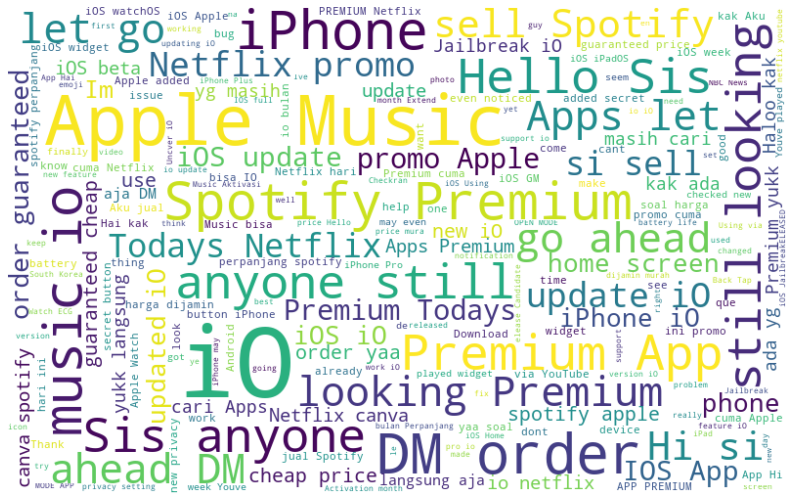

In [31]:
all_words = ' '.join([text for text in tweets_df['absolute_tidy_tweets'][tweets_df.sentiment == 'pos']])
generate_wordcloud(all_words)

##### 4.2 Most common words in negative tweets

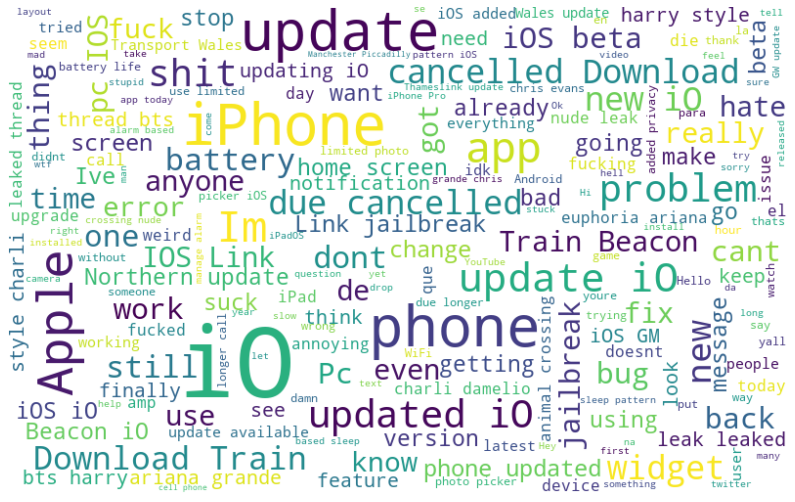

In [32]:
all_words = ' '.join([text for text in tweets_df['absolute_tidy_tweets'][tweets_df.sentiment == 'neg']])
generate_wordcloud(all_words)

##### 4.3 Most commonly used Hashtags

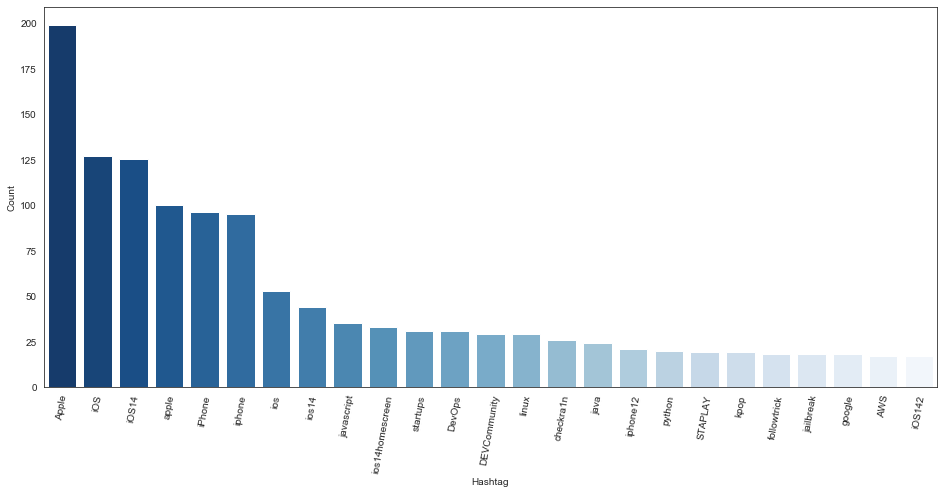

In [33]:
# function to collect hashtags
def hashtag_extract(text_list):
    hashtags = []
    # Loop over the words in the tweet
    for text in text_list:
        ht = re.findall(r"#(\w+)", text)
        hashtags.append(ht)

    return hashtags

def generate_hashtag_freqdist(hashtags):
    a = nltk.FreqDist(hashtags)
    d = pd.DataFrame({'Hashtag': list(a.keys()),
                      'Count': list(a.values())})
    # selecting top 15 most frequent hashtags     
    d = d.nlargest(columns="Count", n = 25)
    fig = plt.figure(figsize=(16,7))
    sns.set_style("white")
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count", palette = 'Blues_r')
    plt.xticks(rotation=80)
    ax.set(ylabel = 'Count')
    plt.show()
    fig.savefig('demo.png', transparent=True)
    
hashtags = hashtag_extract(tweets_df['tweets_en'])
hashtags = sum(hashtags, [])

generate_hashtag_freqdist(hashtags)

In [61]:
positive_tweets = tweets_df[['tweets_en','sentistrength']][tweets_df['sentiment']=='pos']
negative_tweets = tweets_df[['tweets_en', 'sentistrength']][tweets_df['sentiment']=='neg']

In [62]:
positive_tweets.to_csv('positive_reviews.csv')
negative_tweets.to_csv('neagtive_reviews.csv')

In [64]:
negative_tweets

,tweets_en,sentistrength
8,Safari on iOS 14: How to translate websites in...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
9,How to Fix iOS 14 &amp; iPadOS 14 Wi-Fi Problems,"{'neg': 0.231, 'neu': 0.769, 'pos': 0.0, 'comp..."
11,❌ Transport for Wales update: 13:16 Maesteg to...,"{'neg': 0.105, 'neu': 0.895, 'pos': 0.0, 'comp..."
17,Suchitra is the iOS 14.1 of Vanitha. A dangero...,"{'neg': 0.129, 'neu': 0.871, 'pos': 0.0, 'comp..."
22,How to Fix iOS 14 &amp; iPadOS 14 Wi-Fi Problems,"{'neg': 0.231, 'neu': 0.769, 'pos': 0.0, 'comp..."
...,...,...
15519,Apple Seeds New iOS 14.2 Versions Which Stops ...,"{'neg': 0.118, 'neu': 0.882, 'pos': 0.0, 'comp..."
15525,Appleeleases iOS 14.2 GM Fixing Annoying Bug,"{'neg': 0.31, 'neu': 0.69, 'pos': 0.0, 'compou..."
15527,fuck beta iOS 14 like why has it taken the ent...,"{'neg': 0.159, 'neu': 0.727, 'pos': 0.114, 'co..."
15528,Woke up to iOS 14 update. This is mad cool. ❄️,"{'neg': 0.221, 'neu': 0.621, 'pos': 0.159, 'co..."


### 6 Building ML models

#### 6.1 Data pre-processing

In [66]:
tweets_df.head(10)

,tweets_en,absolute_tidy_tweets,key_phrases,sentiment,sentistrength
0,iOS 14 I feel that the battery is exhausted.,iOS I feel battery exhausted,[],pos,"{'neg': 0.263, 'neu': 0.737, 'pos': 0.0, 'comp..."
1,"iPad, it should be able to watch 4K on YouTube...",iPad able watch K YouTube long time good long ...,"[ipad, 4k, youtube, long time, long time, 4k]",pos,"{'neg': 0.0, 'neu': 0.901, 'pos': 0.099, 'comp..."
2,I was updated to ios 14... but I can't decorat...,I updated io I cant decorate,[],pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,how come people display the menu on ios 14 is ...,come people display menu io good,[],pos,"{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'comp..."
4,I wonder if iOS 14.2 will come out 10 or earli...,I wonder iOS come earlier,[],pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
5,"I see ... Wai recently upgraded to iOS 14, and...",I see Wai recently upgraded iOS added feature ...,"[wai, ' t need]",pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
6,#Flossy 😍🤟🏼 Great theme for iOS 14 #WidgetTool...,Great theme iOS BG,"[😍🤟🏼 great theme, ios 14 bg]",pos,"{'neg': 0.0, 'neu': 0.661, 'pos': 0.339, 'comp..."
7,APPLE MUSIC 🔥 (support ios 14) 3 bulan : 25.00...,APPLE MUSIC support io bulan io rb Garansi Akt...,"[apple music 🔥, garansi | aktivasi, perpanjang...",pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
8,Safari on iOS 14: How to translate websites in...,Safari iOS How translate website German,[safari],neg,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
9,How to Fix iOS 14 &amp; iPadOS 14 Wi-Fi Problems,How Fix iOS amp iPadOS WiFi Problems,[ipados 14 wi-fi problems],neg,"{'neg': 0.231, 'neu': 0.769, 'pos': 0.0, 'comp..."


In [37]:
tweets_df = tweets_df[['tweets_en', 'absolute_tidy_tweets', 'key_phrases', 'sentiment', 'sentistrength']]
target_variable = tweets_df['sentiment'].apply(lambda x: 0 if x=='neg' else 1)

tweets_df.head(10)

,tweets_en,absolute_tidy_tweets,key_phrases,sentiment,sentistrength
0,iOS 14 I feel that the battery is exhausted.,iOS I feel battery exhausted,[],pos,"{'neg': 0.263, 'neu': 0.737, 'pos': 0.0, 'comp..."
1,"iPad, it should be able to watch 4K on YouTube...",iPad able watch K YouTube long time good long ...,"[ipad, 4k, youtube, long time, long time, 4k]",pos,"{'neg': 0.0, 'neu': 0.901, 'pos': 0.099, 'comp..."
2,I was updated to ios 14... but I can't decorat...,I updated io I cant decorate,[],pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,how come people display the menu on ios 14 is ...,come people display menu io good,[],pos,"{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'comp..."
4,I wonder if iOS 14.2 will come out 10 or earli...,I wonder iOS come earlier,[],pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
5,"I see ... Wai recently upgraded to iOS 14, and...",I see Wai recently upgraded iOS added feature ...,"[wai, ' t need]",pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
6,#Flossy 😍🤟🏼 Great theme for iOS 14 #WidgetTool...,Great theme iOS BG,"[😍🤟🏼 great theme, ios 14 bg]",pos,"{'neg': 0.0, 'neu': 0.661, 'pos': 0.339, 'comp..."
7,APPLE MUSIC 🔥 (support ios 14) 3 bulan : 25.00...,APPLE MUSIC support io bulan io rb Garansi Akt...,"[apple music 🔥, garansi | aktivasi, perpanjang...",pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
8,Safari on iOS 14: How to translate websites in...,Safari iOS How translate website German,[safari],neg,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
9,How to Fix iOS 14 &amp; iPadOS 14 Wi-Fi Problems,How Fix iOS amp iPadOS WiFi Problems,[ipados 14 wi-fi problems],neg,"{'neg': 0.231, 'neu': 0.769, 'pos': 0.0, 'comp..."


#### Building predictive model using key-words

#### 6.2 Feature extraction

Bag of words (Simple vectorization)

TF-IDF (Term Frequency - Inverse Document Frequency) 

In [71]:
# BOW features
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(tweets_df['absolute_tidy_tweets'])

# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(tweets_df['absolute_tidy_tweets'])

In [72]:
bow_word_feature

<15532x5847 sparse matrix of type '<class 'numpy.int64'>'
	with 116052 stored elements in Compressed Sparse Row format>

In [73]:
from sklearn.model_selection import train_test_split

xtrain_bow, xtest_bow, ytrain_bow, ytest_bow = train_test_split(bow_word_feature, target_variable, test_size=0.3, random_state=272)
xtrain_tfidf, xtest_tfidf, ytrain_tfidf, ytest_tfidf = train_test_split(tfidf_word_feature, target_variable, test_size=0.3, random_state=272)


#### Balancing the classes

In [74]:
import plotly.graph_objects as go
counts = tweets_df['sentiment'].value_counts()
x = ['positive', 'negative']
y = [counts[0], counts[1]]

# Use the hovertext kw argument for hover text
fig = go.Figure(data=[go.Bar(x=x, y=y,
            hovertext=['84% of tweets', '16% of tweets'])])
# Customize aspect
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Class imbalance in the dataset')
fig.show()

In [75]:
from imblearn.combine import SMOTETomek
smk = SMOTETomek(random_state=2)
xtrain_bow_smt, ytrain_bow_smt = smk.fit_sample(xtrain_bow, ytrain_bow)

#visualising the imbalanced data tranform into balanced one after the resampling technique

count_classes = pd.value_counts(ytrain_bow_smt, sort = True)
x = ['positive', 'negative']
y = [count_classes[0], count_classes[1]]

# Use the hovertext kw argument for hover text
fig = go.Figure(data=[go.Bar(x=x, y=y)])
# Customize aspect
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='SMOTETomek - bow')
fig.show()


In [76]:
from imblearn.combine import SMOTETomek
smk = SMOTETomek(random_state=2)
xtrain_tfidf_smt, ytrain_tfidf_smt = smk.fit_sample(xtrain_tfidf, ytrain_tfidf)

#visualising the imbalanced data tranform into balanced one after the resampling technique
count_classes = pd.value_counts(ytrain_tfidf_smt, sort = True)
x = ['positive', 'negative']
y = [count_classes[0], count_classes[1]]

# Use the hovertext kw argument for hover text
fig = go.Figure(data=[go.Bar(x=x, y=y)])
# Customize aspect
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='SMOTETomek - tfidf')
fig.show()

#### Training the data with SVM algorithm

In [77]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(xtrain_bow_smt, ytrain_bow_smt)

ypred_bow = svclassifier.predict(xtest_bow)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(ytest_bow,ypred_bow))

              precision    recall  f1-score   support

           0       0.27      0.57      0.37       563
           1       0.93      0.79      0.86      4097

    accuracy                           0.76      4660
   macro avg       0.60      0.68      0.61      4660
weighted avg       0.85      0.76      0.80      4660



In [78]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(xtrain_tfidf_smt, ytrain_tfidf_smt)

ypred_tfidf = svclassifier.predict(xtest_tfidf)

from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(ytest_tfidf,ypred_tfidf)
print(classification_report(ytest_tfidf,ypred_tfidf))

              precision    recall  f1-score   support

           0       0.46      0.67      0.54       563
           1       0.95      0.89      0.92      4097

    accuracy                           0.86      4660
   macro avg       0.71      0.78      0.73      4660
weighted avg       0.89      0.86      0.88      4660



#### Building models using key-phrases

In [79]:
phrase_sents = tweets_df['key_phrases'].apply(lambda x: ' '.join(x))

# BOW phrase features
bow_phrase_vectorizer = CountVectorizer(max_df=0.90, min_df=2)
bow_phrase_feature = bow_phrase_vectorizer.fit_transform(phrase_sents)

# TF-IDF phrase feature
tfidf_phrase_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2)
tfidf_phrase_feature = tfidf_phrase_vectorizer.fit_transform(phrase_sents)

In [80]:
from sklearn.model_selection import train_test_split

xtrain_bow, xtest_bow, ytrain_bow, ytest_bow = train_test_split(bow_phrase_feature, target_variable, test_size=0.3, random_state=272)
xtrain_tfidf, xtest_tfidf, ytrain_tfidf, ytest_tfidf = train_test_split(tfidf_phrase_feature, target_variable, test_size=0.3, random_state=272)


In [81]:
from imblearn.combine import SMOTETomek
smk = SMOTETomek(random_state=2)
xtrain_bow_smt, ytrain_bow_smt = smk.fit_sample(xtrain_bow, ytrain_bow)

#visualising the imbalanced data tranform into balanced one after the resampling technique

count_classes = pd.value_counts(ytrain_bow_smt, sort = True)
x = ['positive', 'negative']
y = [count_classes[0], count_classes[1]]

# Use the hovertext kw argument for hover text
fig = go.Figure(data=[go.Bar(x=x, y=y)])
# Customize aspect
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='SMOTETomek - bow')
fig.show()


In [82]:
from imblearn.combine import SMOTETomek
smk = SMOTETomek(random_state=2)
xtrain_tfidf_smt, ytrain_tfidf_smt = smk.fit_sample(xtrain_tfidf, ytrain_tfidf)

#visualising the imbalanced data tranform into balanced one after the resampling technique
count_classes = pd.value_counts(ytrain_tfidf_smt, sort = True)
x = ['positive', 'negative']
y = [count_classes[0], count_classes[1]]

# Use the hovertext kw argument for hover text
fig = go.Figure(data=[go.Bar(x=x, y=y)])
# Customize aspect
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='SMOTETomek - tfidf')
fig.show()

In [83]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(xtrain_bow_smt, ytrain_bow_smt)

ypred_bow = svclassifier.predict(xtest_bow)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(ytest_bow,ypred_bow))
print(classification_report(ytest_bow,ypred_bow))

[[ 383  180]
 [1506 2591]]
              precision    recall  f1-score   support

           0       0.20      0.68      0.31       563
           1       0.94      0.63      0.75      4097

    accuracy                           0.64      4660
   macro avg       0.57      0.66      0.53      4660
weighted avg       0.85      0.64      0.70      4660



In [84]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(xtrain_tfidf_smt, ytrain_tfidf_smt)

ypred_tfidf = svclassifier.predict(xtest_tfidf)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(ytest_tfidf,ypred_tfidf))
print(classification_report(ytest_tfidf,ypred_tfidf))

[[ 406  157]
 [1430 2667]]
              precision    recall  f1-score   support

           0       0.22      0.72      0.34       563
           1       0.94      0.65      0.77      4097

    accuracy                           0.66      4660
   macro avg       0.58      0.69      0.55      4660
weighted avg       0.86      0.66      0.72      4660

